In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 15.0 MB/s eta 0:00:00


In [22]:
import torch
import torch.nn as nn
import json
import random
# from transformers import BertForSequenceClassification, AdamW, BertConfig
# from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
import re
import numpy as np
import emoji
# from transformers import *
from tqdm import tqdm
# from sklearn.model_selection import StratifiedKFold
# from transformers import BertTokenizer
# from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import accuracy_score,f1_score
from sklearn.utils.class_weight import compute_class_weight
# from transformers import BertTokenizer
# from transformers import BertForSequenceClassification, AdamW, BertConfig
# from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from sklearn.metrics import *
from sklearn.utils import *
import pandas as pd
import string

In [23]:
d1= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_en_l1.csv')
d1_test= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_en_l1.csv')
d1

,text,key,en_a1,en_a2,en_a3,en_a4,en_a5,en_a6
0,"This is our history . For Shia and Sunni ,...",question_1,NaN,NaN,NaN,NaN,NaN,0.0
1,"If this is ""grilling"" then wht wud u call t...",question_1,NaN,NaN,NaN,1.0,NaN,NaN
2,look at <handle replaced>madam. Locals attac...,question_1,NaN,NaN,NaN,NaN,0.0,NaN
3,our beloved yogi ji has given money home and...,question_1,NaN,NaN,NaN,NaN,1.0,NaN
4,"""I gonna kill that bitch"" Bitvj imma kill you...",question_1,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...
6526,“mama let’s research” bitch suck my dick 😭,question_1,NaN,NaN,NaN,NaN,0.0,NaN
6527,😂😂😂😂 I WAS BY MYSELF AND IT WAS HER AND HER BI...,question_1,NaN,NaN,NaN,NaN,0.0,NaN
6528,😂😂😂😂😂😂😂😂😂 i just seen a comment and bitch IM C...,question_1,NaN,NaN,NaN,NaN,0.0,NaN
6529,"😎""Boys Only Luxury!!!!!!!!!!!!!!!!!!!!!!!!!!!""...",question_1,0.0,1.0,1.0,0.0,NaN,NaN


In [24]:
def normalize_text(text):
  # emoji_pattern = re.compile("["
  #                             u"\U0001F600-\U0001F64F"  # emoticons
  #                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
  #                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
  #                             u"\U0001F700-\U0001F77F"  # alchemical symbols
  #                             u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
  #                             u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
  #                             u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
  #                             u"\U0001FA00-\U0001FA6F"  # Chess Symbols
  #                             u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
  #                             u"\U00002702-\U000027B0"  # Dingbats
  #                             u"\U000024C2-\U0001F251"
  #                             "]+", flags=re.UNICODE)
  text = text.lower()
  text = re.sub('\[.*?\]', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', ' ', text)
  text = re.sub('<handle replaced>', '', text)
  text = emoji.demojize(text)
  text = text.replace("ðŸ¤§", " ")
  text = text.replace("&amp;", " ")
  text = text.replace("\n", " ")
  text = text.replace("ðŸ˜¡", " ")
  # text = emoji_pattern.sub(r'', text)
  return text

d1['text'] = d1['text'].apply(lambda x: normalize_text(x))
d1_test['text'] = d1_test['text'].apply(lambda x: normalize_text(x))

In [25]:
d1

,text,key,en_a1,en_a2,en_a3,en_a4,en_a5,en_a6
0,this is our history for shia and sunni ...,question_1,NaN,NaN,NaN,NaN,NaN,0.0
1,if this is grilling then wht wud u call t...,question_1,NaN,NaN,NaN,1.0,NaN,NaN
2,look at madam locals attacked no religion...,question_1,NaN,NaN,NaN,NaN,0.0,NaN
3,our beloved yogi ji has given money home and...,question_1,NaN,NaN,NaN,NaN,1.0,NaN
4,i gonna kill that bitch bitvj imma kill you...,question_1,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...
6526,“mama let’s research” bitch suck my dick :loud...,question_1,NaN,NaN,NaN,NaN,0.0,NaN
6527,:face_with_tears_of_joy::face_with_tears_of_jo...,question_1,NaN,NaN,NaN,NaN,0.0,NaN
6528,:face_with_tears_of_joy::face_with_tears_of_jo...,question_1,NaN,NaN,NaN,NaN,0.0,NaN
6529,:smiling_face_with_sunglasses: boys only luxur...,question_1,0.0,1.0,1.0,0.0,NaN,NaN


In [26]:
X1 = list(d1['text'])
X1_test = list(d1_test['text'])

col_lst = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
for col in col_lst:
    d1[col] = pd.to_numeric(d1[col], errors='coerce')
    d1_test[col] = pd.to_numeric(d1_test[col], errors='coerce')


d1['label'] = d1[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values
d1_test['label'] = d1_test[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values


d1 = d1.drop(col_lst, axis=1)
d1_test = d1_test.drop(col_lst, axis=1)


d1['label'] = d1['label'].astype(int)
d1_test['label'] = d1_test['label'].astype(int)


d1 = d1[['label', 'text']]
d1_test = d1_test[['label', 'text']]
d1_test

,label,text
0,1,who s this tweet about bitch it s about you ...
1,0,alkalamba should’ve used her slippers to slap...
2,1,coronavillains covididiot is a do...
3,1,acts like the female governors of stat...
4,1,let us celebrate “secular” as a beautiful w...
...,...,...
1102,1,you should be tired of not having any kind of ...
1103,0,“the limits of tyrants are prescribed by the e...
1104,1,:Cancer::crab: like wtf my symbol is and i’m...
1105,1,:United_States: marry a millionaire guy divo...


In [27]:
y_data1 = d1["label"]
y1 = y_data1.values

print(y1)
print(len(y1))

[0 1 0 ... 0 1 0]
6531


In [28]:
# def getPerformanceOfLoader(test_dataloader):
#     model.eval()
#     # Tracking variables
#     predictions , true_labels = [], []
#     # Predict
#     for batch in test_dataloader:
#     #print(batch)
#     # Add batch to GPU
#         batch = tuple(t.to(device) for t in batch)

#         # Unpack the inputs from our dataloader
#         b_input_ids, b_input_mask, b_labels = batch

#         # Telling the model not to compute or store gradients, saving memory and
#         # speeding up prediction
#         with torch.no_grad():
#             # Forward pass, calculate logit predictions
#             outputs = model(b_input_ids, token_type_ids=None,
#                       attention_mask=b_input_mask)

#         logits = outputs[0]

#         # Move logits and labels to CPU
#         logits = logits.detach().cpu().numpy()
#         label_ids = b_labels.to('cpu').numpy()
#         # Store predictions and true labels
#         pred_flat = np.argmax(logits, axis=1).flatten()
#         predictions.extend(pred_flat)
#         true_labels.extend(label_ids)

#     df = pd.DataFrame()
#     df['id']=testData['text']
#     df['target'] = predictions

#     return df

In [34]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load the tokenizer and model
model_name = "Hate-speech-CNERG/english-abusive-MuRIL"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
print("=====================")
print(model)
print("=====================")
model.eval()

def get_predictions(df):
    y_true = df['label'].tolist()
    y_pred = []

    for text in tqdm(df['text'], desc="Predicting"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=1)
            pred = torch.argmax(probs, dim=1).item()
            y_pred.append(pred)

    return y_true, y_pred

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--Hate-speech-CNERG--english-abusive-MuRIL/snapshots/ac6434a0987130c9c7d676a797fcedec38bd4593/vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--Hate-speech-CNERG--english-abusive-MuRIL/snapshots/ac6434a0987130c9c7d676a797fcedec38bd4593/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--Hate-speech-CNERG--english-abusive-MuRIL/snapshots/ac6434a0987130c9c7d676a797fcedec38bd4593/tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Hate-speech-CNERG--english-abusive-MuRIL/snapshots/ac6434a0987130c9c7d676a797fcedec38bd4593/config.json
Model config BertConfig {
  "architectures": [
    "BertForSequenceClassifica

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evalMetric(y_true, y_pred):
    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    mf1Score = f1_score(y_true, y_pred, average='macro')
    f1Score  = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    area_under_c = auc(fpr, tpr)
    recallScore = recall_score(y_true, y_pred)
    precisionScore = precision_score(y_true, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Non-Abusive', 'Abusive']

    # Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        "accuracy": accuracy,
        "mF1Score": mf1Score,
        "f1Score": f1Score,
        "auc": area_under_c,
        "precision": precisionScore,
        "recall": recallScore
    }


Predicting: 100%|██████████| 1107/1107 [03:37<00:00,  5.09it/s]


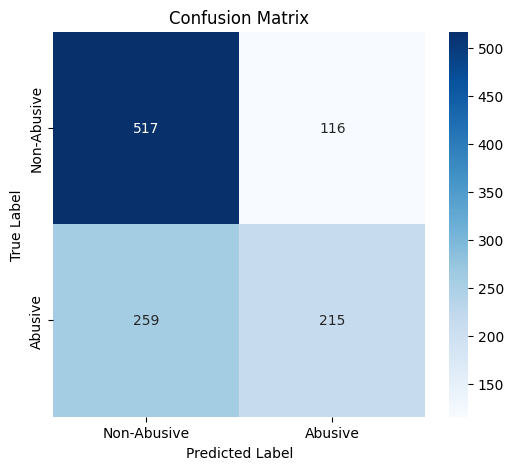

Evaluation Metrics:
 {'accuracy': 0.6612466124661247, 'mF1Score': 0.6340076438511961, 'f1Score': 0.5341614906832298, 'auc': np.float64(0.6351660767492551), 'precision': 0.649546827794562, 'recall': 0.45358649789029537}


In [36]:
# d1_subset = d1.head(200)
y_true, y_pred = get_predictions(d1_test)

# Evaluate
metrics = evalMetric(y_true, y_pred)
print("Evaluation Metrics:\n", metrics)